<a href="https://colab.research.google.com/github/kashishkhera44/comp215/blob/main/labs/lab08_GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name:
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [2]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [3]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

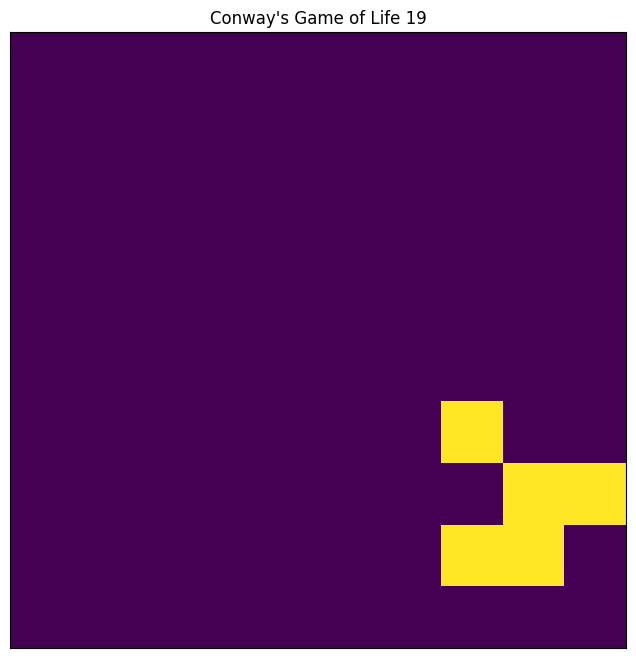

In [ ]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

In [7]:
# Ex. 1 your code here...
unique_state = 2**9
print(f"Number of unique states for a 3x3 neighbourhood: {unique_state}")
rules = 2**512
print(f"Number of unique rules: {rules}")

#The estimated number of atoms in observable universe is 10^8 but is significantly smaller than 2^512. Therefore it is difficult to comprehend difference between these 2 numbers.

Number of unique states for a 3x3 neighbourhood: 512
Number of unique rules: 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. No, wolfram-like experiment for 2D CAs would be computationally expensive because of the large number of rules.
2. We would need a binary string of length 512 to cover all possible nighbourhood states.
3. List all 512 possible neighborhood patterns.
Apply Conway's rules to each pattern to determine if the center cell lives or dies.
Create a 512-bit binary string representing the outcomes (0 for dead, 1 for alive).
Convert the binary string to a decimal number this is the rule number.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

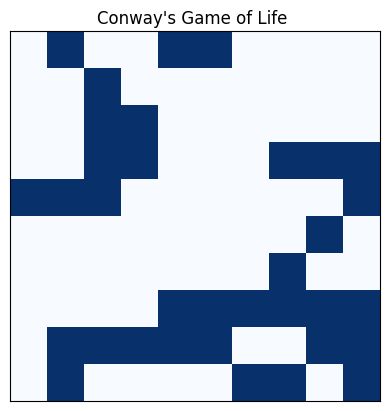

In [11]:
# Ex. 2 experimental setup

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        # Ex. 2 your code here...
        self.state = np.random.choice([0, 1], size=self.state.shape, p=[1-p, p])


def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    # Ex. 2 your code here...
    life = BetterLife2D(n_rows, n_cols)
    life.randomize_state(p)
    return life

my_life = random_life(10, p=0.3)

my_life.step()
my_life.draw()

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

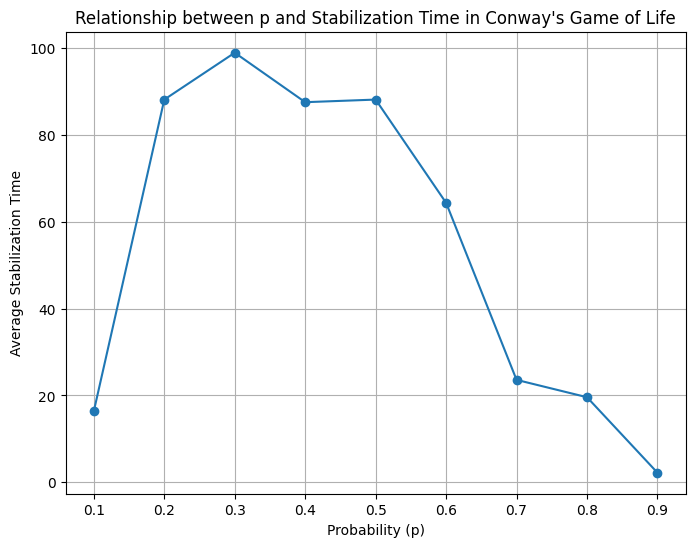

In [25]:
# Ex. 2 write code for your experiment here..
def is_stable(life, prev_states):
    """Check if the Game of Life has stabilized by comparing to previous states."""
    return any(np.array_equal(life.state, prev_state) for prev_state in prev_states)

def stabilization_time(n_rows, n_cols, p, max_steps=100):
    """Simulate and measure the time to stabilization for a given p."""
    life = random_life(n_rows, n_cols, p)
    prev_states = [life.state.copy()]
    for step in range(1, max_steps + 1):
        life.step()
        if is_stable(life, prev_states):
            return step
        prev_states.append(life.state.copy())
    return max_steps


n_rows = 20
n_cols = 20
p_values = np.arange(0.1, 1.0, 0.1)
repetitions = 5

results = {}
for p in p_values:
    stabilization_times = []
    for _ in range(repetitions):
        stabilization_times.append(stabilization_time(n_rows, n_cols, p))
    results[p] = stabilization_times

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(results.keys(), [np.mean(times) for times in results.values()], marker='o')
plt.xlabel("Probability (p)")
plt.ylabel("Average Stabilization Time")
plt.title("Relationship between p and Stabilization Time in Conway's Game of Life")
plt.grid(True)
plt.show()

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [28]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Ex. 3 your code here...
class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        # Ex. 2 your code here...
        self.state = np.random.choice([0, 1], size=self.state.shape, p=[1-p, p])

    def load_pattern(self, x, y, pattern_array):
        """Loads a pattern into the game grid at the specified location (x,y)."""
        pattern_height, pattern_width = pattern_array.shape
        self.state[y:y + pattern_height, x:x + pattern_width] = pattern_array

### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [31]:
# Ex. 3 define your patterns here...
glider_pattern = \
    """
    010
    001
    111
    """
lwss_pattern = """
00110
11011
10001
01111
"""
blinker_pattern = """
111
"""
block_pattern = """
11
11
"""
toad_pattern = """
0111
1110
"""
beacon_pattern = """
1100
1100
0011
0011
"""
glider_array = pattern_to_array(glider_pattern)
lwss_array = pattern_to_array(lwss_pattern)
blinker_array = pattern_to_array(blinker_pattern)
block_array = pattern_to_array(block_pattern)
toad_array = pattern_to_array(toad_pattern)
beacon_array = pattern_to_array(beacon_pattern)

### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

In [38]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

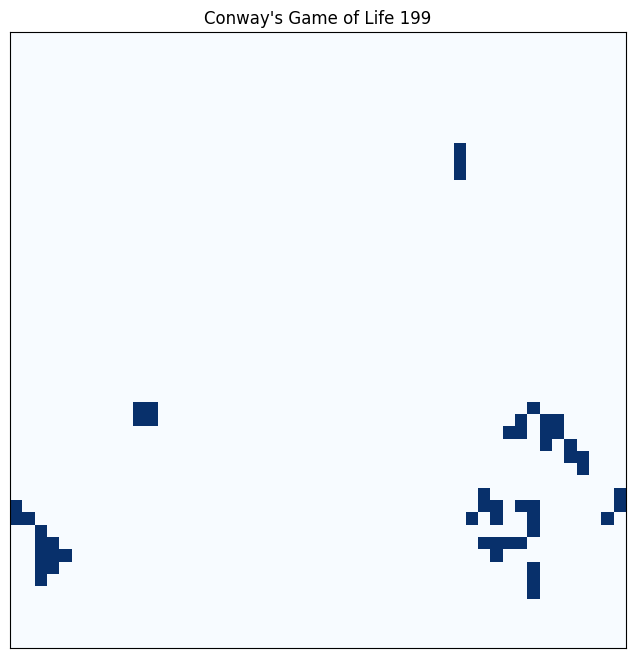

"\n- Glider Movement: Observe how the glider moves across the grid. It translates diagonally.\n- LWSS Behavior: The lightweight spaceship (LWSS) also moves, but in a different pattern.\n- Blinker Oscillation: The blinker will oscillate between a horizontal and vertical line.\n- Block Stability: The block remains stable and unchanged throughout the simulation.\n- Toad Oscillation: The toad will oscillate between two states.\n- Interactions: Look for any interesting interactions between the patterns, such as collisions or near misses.\n\nReal-world Applicability:\n- Cellular Automata like Conway's Game of Life can be used to model various real-world phenomena, such as:\n    - Biological systems (cell growth, pattern formation)\n    - Chemical reactions (diffusion, pattern formation)\n    - Physical systems (crystal growth, fluid dynamics)\n    - Social systems (spread of ideas, opinion dynamics)\n"

In [39]:
# Ex. 3 code for your experiment here
# Ex. 3 define your patterns here...
# ... (Your existing pattern definitions) ...

def pattern_to_array(pattern_string):
    """Converts a pattern string to a NumPy array."""
    lines = pattern_string.strip().split('\n')
    array = [[int(char) for char in line.strip() if char.isdigit()] for line in lines]  # Remove spaces from each line and ensure only digits
    return np.array(array, dtype=np.uint8)

glider_array = pattern_to_array(glider_pattern)
lwss_array = pattern_to_array(lwss_pattern)
blinker_array = pattern_to_array(blinker_pattern)
block_array = pattern_to_array(block_pattern)
toad_array = pattern_to_array(toad_pattern)
beacon_array = pattern_to_array(beacon_pattern)

# Ex. 3 code for your experiment here
# Create a BetterLife2D object with a larger grid
life = BetterLife2D(50, 50)

# Load patterns into the grid with strategic spacing
life.load_pattern(5, 5, glider_array)
life.load_pattern(20, 20, lwss_array)
life.load_pattern(35, 10, blinker_array)
life.load_pattern(10, 30, block_array) # Changed block_pattern to block_array
life.load_pattern(40, 40, toad_array) # Changed toad_pattern to toad_array

# Create an animation with more frames for observation
gol = Animation2D(life, frames=200) # Increased frames
gol.animate(interval=0.15)  # Adjusted for smoother visualization

# Observations and Insights:
"""
- Glider Movement: It translates diagonally.
- LWSS Behavior: The lightweight spaceship (LWSS) also moves, but in a different pattern.
- Blinker Oscillation: The blinker will oscillate between a horizontal and vertical line.
- Block Stability: The block remains stable and unchanged throughout the simulation.
- Toad Oscillation: The toad will oscillate between two states.

Real-world Applicability:
- Cellular Automata like Conway's Game of Life can be used to model various real-world phenomena, such as:
    - Biological systems (cell growth, pattern formation)
    - Chemical reactions (diffusion, pattern formation)
    - Social systems (spread of ideas, opinion dynamics)
"""